In [189]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.api as sm

In [23]:
NAO_df = pd.read_csv("norm.daily.nao.cdas.z500.19500101_current.csv")

In [24]:
# convert to datetime format and set as index 
NAO_df['date'] = pd.to_datetime(NAO_df[['year', 'month', 'day']])
# Drop the individual year, month, day columns if needed
NAO_df.drop(columns=['year', 'month', 'day'], inplace=True)
NAO_df.set_index('date', inplace=True)

print(NAO_df)

            nao_index_cdas
date                      
1950-01-01        0.365000
1950-01-02        0.096000
1950-01-03       -0.416000
1950-01-04       -0.616000
1950-01-05       -0.261000
...                    ...
2024-05-08        0.246422
2024-05-09        0.475453
2024-05-10        0.656409
2024-05-11        0.688005
2024-05-12        0.517683

[27161 rows x 1 columns]


In [25]:
# calculate monthly mean and adding to the datafram
# Calculate monthly mean
monthly_mean = NAO_df.resample('M').mean()

# Broadcast monthly mean to each day within the same month
monthly_mean_broadcasted = monthly_mean.reindex(NAO_df.index, method='bfill')

# Merge the broadcasted monthly mean back to the original DataFrame
NAO_df['monthly_mean'] = monthly_mean_broadcasted


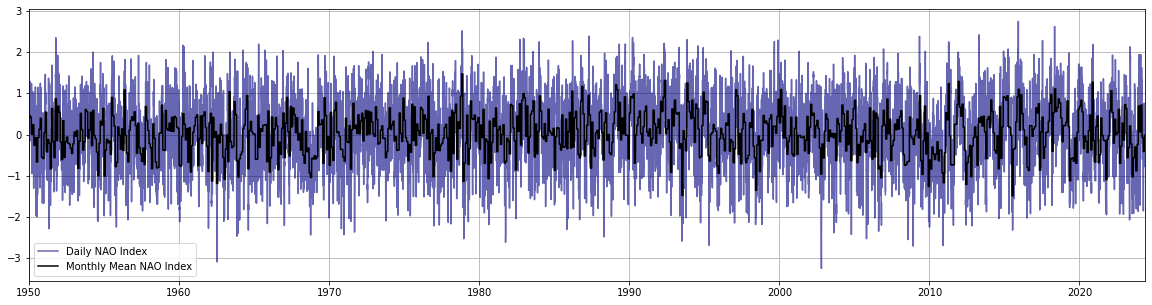

In [136]:
#simple visulization of the time series
plt.figure(figsize=[20,5])
plt.plot(NAO_df["nao_index_cdas"],alpha=0.6,label="Daily NAO Index",color="navy")
plt.plot(NAO_df["monthly_mean"],label="Monthly Mean NAO Index",color="k")
plt.xlim(-7305,19855)
plt.legend()
plt.grid()

## Stochastic Analysis

In [147]:
#check for missing values:
print("Found " + str(pd.isna(NAO_df["nao_index_cdas"].values).sum()) + " missing values in the dataframe.")

Found 2 missing values in the dataframe


In [161]:
# Find missing values
np.where(pd.isna(NAO_df["nao_index_cdas"])==True)
print(NAO_df.index[[20752, 20844]])
# interpolate missing values
NAO_df["nao_index_cdas"] = NAO_df["nao_index_cdas"].interpolate(method='linear')

DatetimeIndex(['2006-10-26', '2007-01-26'], dtype='datetime64[ns]', name='date', freq=None)


In [162]:
# check again:
print("Found " + str(pd.isna(NAO_df["nao_index_cdas"].values).sum()) + " missing values in the dataframe.")

Found 0 missing values in the dataframe.


In [163]:
st.describe(NAO_df["nao_index_cdas"].values)

DescribeResult(nobs=27161, minmax=(-3.253999948501587, 2.75131893157959), mean=0.024614994430646648, variance=0.6627721189806259, skewness=-0.16461672012245565, kurtosis=-0.18338520489978505)

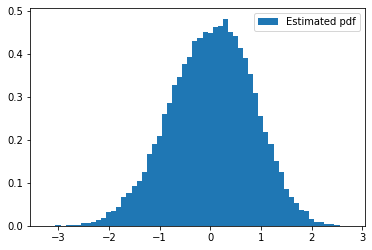

In [184]:
plt.hist(NAO_df["nao_index_cdas"],bins=60,density=True,label="Estimated pdf")
plt.legend()
plt.show()

In [175]:
st.describe(NAO_df["nao_index_cdas"]["1950":"1980"])

DescribeResult(nobs=11323, minmax=(-3.095000028610229, 2.5199999809265137), mean=-0.025210809759961154, variance=0.6255226680459232, skewness=-0.14895231648517193, kurtosis=-0.22425763828848044)

In [176]:
st.describe(NAO_df["nao_index_cdas"]["1980":"2009"])

DescribeResult(nobs=10958, minmax=(-3.253999948501587, 2.3940000534057617), mean=0.068958160738376, variance=0.6694916989023104, skewness=-0.23589712583723524, kurtosis=-0.06498461759629937)

In [181]:
st.describe(NAO_df["nao_index_cdas"]["2010"])

DescribeResult(nobs=365, minmax=(-2.69617247581482, 1.1569489240646362), mean=-0.5796321871186517, variance=0.4429502599437567, skewness=-0.33112687504723515, kurtosis=0.36953782653447664)

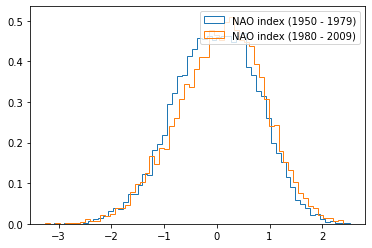

In [182]:
plt.hist(NAO_df["nao_index_cdas"]["1950":"1979"],bins=60,histtype="step",density=True,label="NAO index (1950 - 1979)")
plt.hist(NAO_df["nao_index_cdas"]["1980":"2009"],bins=60,histtype="step",density=True,label="NAO index (1980 - 2009)")
#plt.hist(NAO_df["nao_index_cdas"]["2010":],bins=60,histtype="step",density=True,label="NAO index (2010 - 2024(May))")
plt.legend()
plt.show()

(0.0, 500.0)

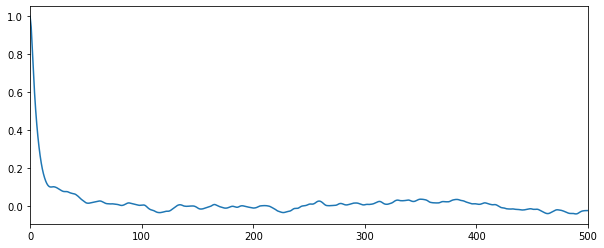

In [193]:
# autocorrelation function:
autocorr_NAO = sm.tsa.acf(NAO_df["nao_index_cdas"], nlags=500)
plt.figure(figsize=[10,4])
plt.plot(autocorr_NAO)
plt.xlim(0,500)

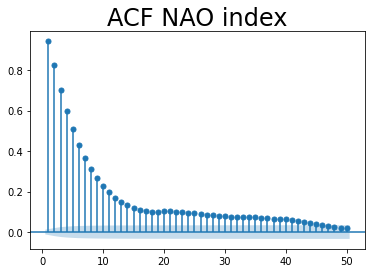

In [188]:
import statsmodels.graphics.tsaplots as sgt
sgt.plot_acf(NAO_df["nao_index_cdas"], lags = 60, zero = False)
plt.title("ACF NAO index", size = 24)
plt.show()

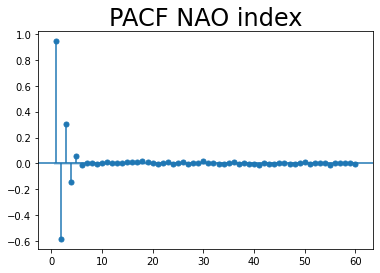

In [196]:
sgt.plot_pacf(NAO_df["nao_index_cdas"], lags = 60, zero = False, method = ('ols'))
plt.title("PACF NAO index", size = 24)
plt.show()

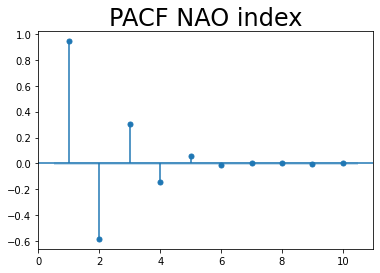

In [197]:
sgt.plot_pacf(NAO_df["nao_index_cdas"], lags = 10, zero = False, method = ('ols'))
plt.title("PACF NAO index", size = 24)
plt.show()

In [198]:
import statsmodels.tsa.stattools as sts
sts.adfuller(NAO_df["nao_index_cdas"])

(-26.939653200313437,
 0.0,
 18,
 27142,
 {'1%': -3.43059095197697,
  '5%': -2.8616464938489705,
  '10%': -2.5668266834976325},
 -8311.488489157477)

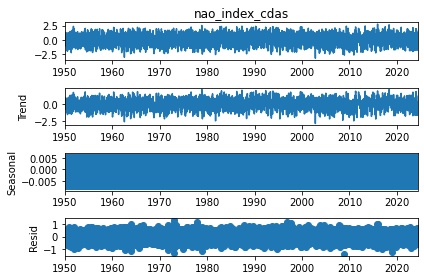

In [200]:
from statsmodels.tsa.seasonal import seasonal_decompose
s_dec_multiplicative = seasonal_decompose(NAO_df["nao_index_cdas"], model = "additive")
s_dec_multiplicative.plot()
plt.show()

## Power Spectral Analysis

In [66]:
time = np.arange(0,len(monthly_mean))#*(60*60*24*30)
N = np.shape(monthly_mean)[0]
T = np.array(np.shape(time))
df = 1/T
f_vec = df * np.arange(int(N))[1:int(N/2)]


C:\Users\User\AppData\Roaming\Python\Python37\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


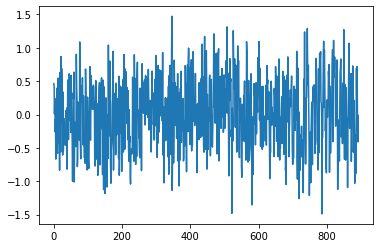

In [64]:
plt.plot(fft_result)

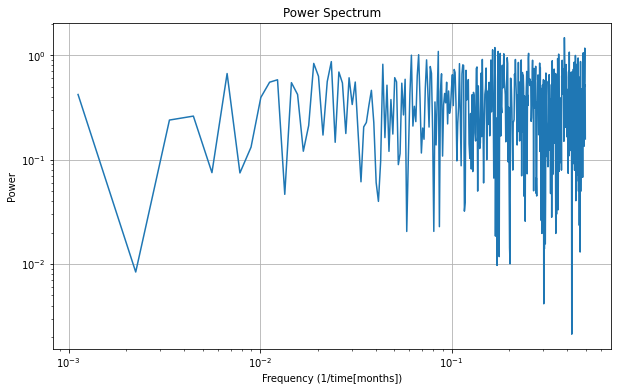

In [70]:
# sprectral analysis
# Perform Fourier Transform (FFT)
fft_result = np.abs(np.fft.fft(monthly_mean))[1:int(N/2)]
#freq = np.fft.fftfreq(len(monthly_mean), d=1)  # Frequency bins in months

# Calculate power spectrum
#power_spectrum = np.abs(fft_result)**2

# Plot the results
plt.figure(figsize=(10, 6))
plt.loglog(f_vec, fft_result)
plt.title('Power Spectrum')
plt.xlabel('Frequency (1/time[months])')
plt.ylabel('Power')
plt.grid(True)
plt.show()